In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
BATCH_SIZE = 16
EPOCHS = 25

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


validation에 이용할 값이 지나치게 적기 때문에 train 값과 validation 값을 합친 후 80:20의 비율로 재분할한다.

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


파일 경로를 확인해본 결과 폐렴에 감염되지 않았을 경우 경로 내에 NORMAL이 포함되어 있고, 폐렴에 감염되었을 경우 PNEUMONIA를 포함하고 있다는 것을 알 수 있었다. 이를 이용해 정상 이미지와 폐렴이미지의 수를 셀 수 있다.


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [8]:
# mini-batch를 이용하기 위해 tf.data 인스턴스 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없기 때문에 파일 경로에 있는 단어를 이용해 라벨 데이터를 만들어준다.

In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 사이즈가 제각각일 가능성이 크기 때문에, 이미지 사이즈를 통일하고 GPU 메모리를 효율적으로 사용하고자 이미지 크기를 일정하게 줄이도록 한다.

In [11]:
# 이미지를 알맞은 형식으로 변경
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옴
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # 고정 크기 버퍼 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) 
    # 데이터셋을 여러 번 사용할 수 있게 함
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # 학습데이터를 나눠서 읽어옴
    # 첫 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비 가능
    # 리소스의 유휴 상태를 줄일 수 있음
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

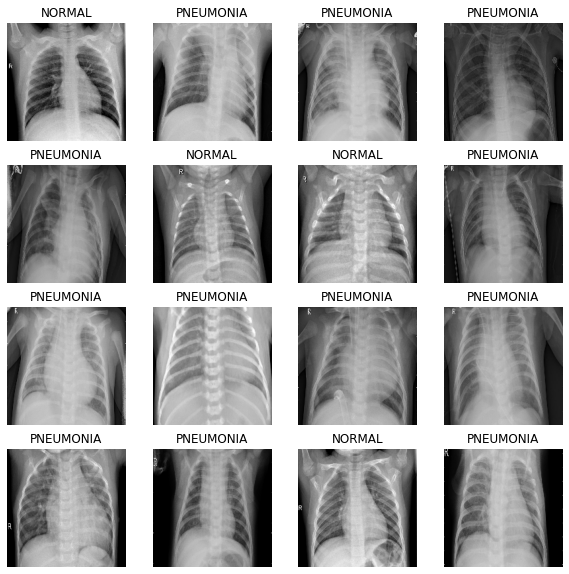

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델 생성
- conv_block, dense_block 함수 생성
- dense_block: normalization, dropout이라는 두 가지 regulation을 같이 사용
  - 두 가지 정규화 방법을 함께 사용한다는 점에 관해서는 의견이 나뉘기 때문에 두 가지 를 모두 사용하는 경우와 그렇지 않은 경우를 나누어 성능을 비교해볼 수 있을 것. 

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 불균형 처리
- weight balancing 활용
  - training set에서 각 데이터의 loss를 계산할 때 특정 클래스의 데이터가 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
  - keras에서 model.fit() 호출 시 class_weight로 설정 가능

In [20]:
# Normal과 Pneumonia의 전체 데이터 수에 반비례하도록 weight 설정
# Normal 이미지에 사용할 weight
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
# Pneumonia 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 87s 190ms/step - loss: 0.4769 - accuracy: 0.7421 - precision: 0.9323 - recall: 0.7044 - val_loss: 0.5896 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2461 - accuracy: 0.9040 - precision: 0.9741 - recall: 0.8947 - val_loss: 1.1424 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1809 - accuracy: 0.9296 - precision: 0.9783 - recall: 0.9260 - val_loss: 0.1589 - val_accuracy: 0.9288 - val_precision: 0.9197 - val_recall: 0.9895
Epoch 4/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1711 - accuracy: 0.9351 - precision: 0.9781 - recall: 0.9337 - val_loss: 0.3022 - val_accuracy: 0.9115 - val_precision: 0.9941 - val_recall: 0.8850
Epoch 5/25
261/261 [==============================] - 51s 198ms/step - loss: 0.1512 - accura

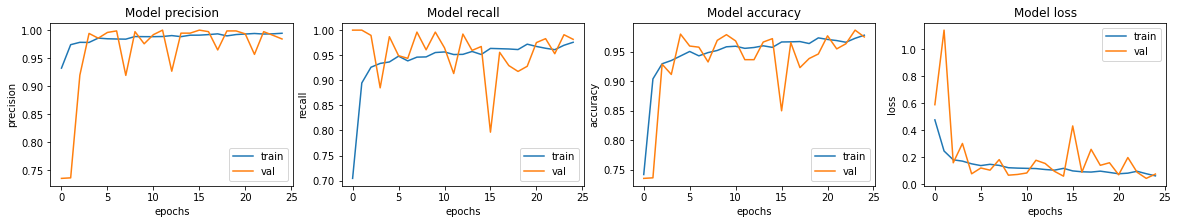

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 115ms/step - loss: 1.2854 - accuracy: 0.7644 - precision: 0.7288 - recall: 0.9923
Loss: 1.2854212522506714,
Accuracy: 0.7644230723381042,
Precision: 0.7288135886192322,
Recall: 0.9923076629638672


## 성능개선
1. batch size, epochs 변경
2. agumentation 방법 추가
3. 정규화 방법 변경


### 1. batch size, epochs 변경

In [25]:
BATCH_SIZE = 20
EPOCHS = 30
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
209/209 [==============================] - 49s 199ms/step - loss: 0.0654 - accuracy: 0.9758 - precision: 0.9947 - recall: 0.9728 - val_loss: 0.0621 - val_accuracy: 0.9760 - val_precision: 0.9933 - val_recall: 0.9737
Epoch 2/30
209/209 [==============================] - 42s 201ms/step - loss: 0.0713 - accuracy: 0.9740 - precision: 0.9929 - recall: 0.9716 - val_loss: 0.1056 - val_accuracy: 0.9543 - val_precision: 1.0000 - val_recall: 0.9386
Epoch 3/30
209/209 [==============================] - 41s 196ms/step - loss: 0.0702 - accuracy: 0.9779 - precision: 0.9955 - recall: 0.9748 - val_loss: 0.1349 - val_accuracy: 0.9519 - val_precision: 0.9915 - val_recall: 0.9431
Epoch 4/30
209/209 [==============================] - 43s 205ms/step - loss: 0.0673 - accuracy: 0.9728 - precision: 0.9947 - recall: 0.9688 - val_loss: 0.0492 - val_accuracy: 0.9856 - val_precision: 0.9886 - val_recall: 0.9918
Epoch 5/30
209/209 [==============================] - 43s 207ms/step - loss: 0.0645 - accura

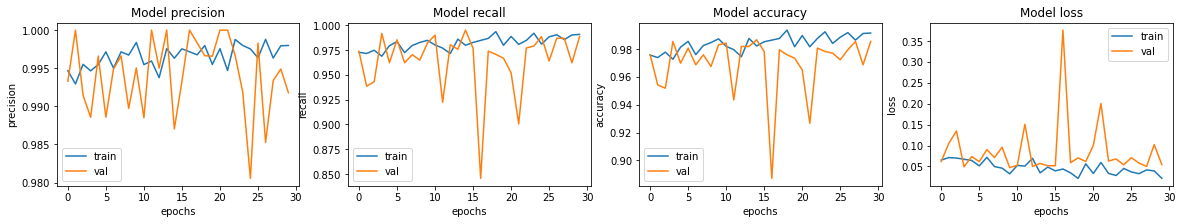

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
be_loss, be_accuracy, be_precision, be_recall = model.evaluate(test_ds)
print(f'Loss: {be_loss},\nAccuracy: {be_accuracy},\nPrecision: {be_precision},\nRecall: {be_recall}')

39/39 [==============================] - 4s 106ms/step - loss: 1.6956 - accuracy: 0.7837 - precision: 0.7438 - recall: 0.9974
Loss: 1.6956491470336914,
Accuracy: 0.7836538553237915,
Precision: 0.7437858581542969,
Recall: 0.9974358677864075


batch size가 16, epochs가 25일때 비해 batch size가 20, epochs가 30일 때 성능이 더 발전하였다.

### 2. agumentation 도입

In [28]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


In [29]:
BATCH_SIZE = 16
EPOCHS = 25

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 68s 223ms/step - loss: 0.0779 - accuracy: 0.9730 - precision: 0.9918 - recall: 0.9716 - val_loss: 0.0814 - val_accuracy: 0.9738 - val_precision: 0.9989 - val_recall: 0.9658
Epoch 2/25
261/261 [==============================] - 58s 224ms/step - loss: 0.0510 - accuracy: 0.9830 - precision: 0.9958 - recall: 0.9813 - val_loss: 0.2110 - val_accuracy: 0.9315 - val_precision: 1.0000 - val_recall: 0.9084
Epoch 3/25
261/261 [==============================] - 58s 222ms/step - loss: 0.0419 - accuracy: 0.9852 - precision: 0.9966 - recall: 0.9834 - val_loss: 0.0640 - val_accuracy: 0.9769 - val_precision: 0.9925 - val_recall: 0.9758
Epoch 4/25
261/261 [==============================] - 59s 225ms/step - loss: 0.0413 - accuracy: 0.9856 - precision: 0.9966 - recall: 0.9840 - val_loss: 0.0903 - val_accuracy: 0.9700 - val_precision: 0.9989 - val_recall: 0.9602
Epoch 5/25
261/261 [==============================] - 61s 233ms/step - loss: 0.0414 - accura

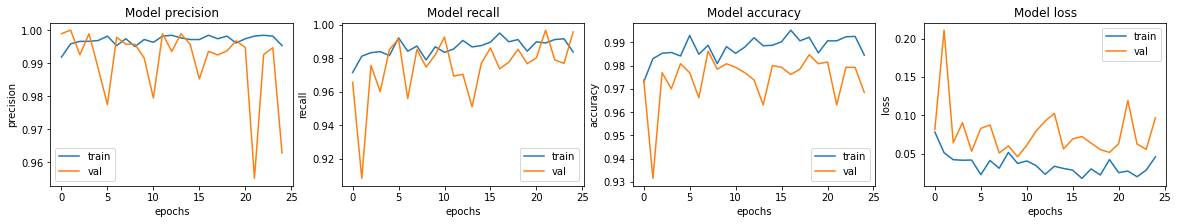

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 115ms/step - loss: 2.1065 - accuracy: 0.6955 - precision: 0.6724 - recall: 1.0000
Loss: 2.106511116027832,
Accuracy: 0.6955128312110901,
Precision: 0.6724137663841248,
Recall: 1.0


### 3. 정규화 방법 변경

dropout만 사용함

In [32]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [33]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [34]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 69s 229ms/step - loss: 0.3855 - accuracy: 0.8197 - precision: 0.9347 - recall: 0.8156 - val_loss: 0.6610 - val_accuracy: 0.7392 - val_precision: 0.7392 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 59s 226ms/step - loss: 0.2207 - accuracy: 0.9059 - precision: 0.9807 - recall: 0.8908 - val_loss: 2.4229 - val_accuracy: 0.7392 - val_precision: 0.7392 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 58s 224ms/step - loss: 0.1823 - accuracy: 0.9259 - precision: 0.9772 - recall: 0.9214 - val_loss: 0.3557 - val_accuracy: 0.8638 - val_precision: 0.8446 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 58s 221ms/step - loss: 0.1556 - accuracy: 0.9372 - precision: 0.9829 - recall: 0.9319 - val_loss: 0.0778 - val_accuracy: 0.9700 - val_precision: 0.9720 - val_recall: 0.9874
Epoch 5/25
261/261 [==============================] - 60s 229ms/step - loss: 0.1405 - accura

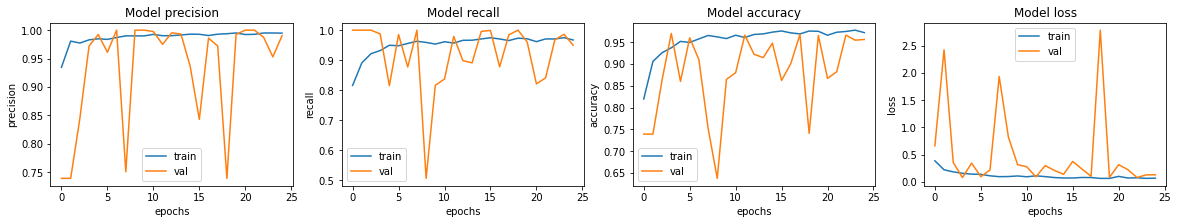

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [36]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 1.5096 - accuracy: 0.7981 - precision: 0.7683 - recall: 0.9692
Loss: 1.5096379518508911,
Accuracy: 0.7980769276618958,
Precision: 0.7682926654815674,
Recall: 0.9692307710647583


Batch Normalization만 사용

In [37]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block

In [38]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [39]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 69s 228ms/step - loss: 0.2674 - accuracy: 0.8921 - precision: 0.9697 - recall: 0.8825 - val_loss: 0.6886 - val_accuracy: 0.7415 - val_precision: 0.7415 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 58s 223ms/step - loss: 0.1723 - accuracy: 0.9320 - precision: 0.9759 - recall: 0.9313 - val_loss: 1.3109 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 60s 229ms/step - loss: 0.1464 - accuracy: 0.9416 - precision: 0.9833 - recall: 0.9377 - val_loss: 0.2124 - val_accuracy: 0.9008 - val_precision: 0.8813 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 60s 231ms/step - loss: 0.1194 - accuracy: 0.9533 - precision: 0.9850 - recall: 0.9515 - val_loss: 0.0982 - val_accuracy: 0.9569 - val_precision: 0.9537 - val_recall: 0.9896
Epoch 5/25
261/261 [==============================] - 61s 233ms/step - loss: 0.1229 - accura

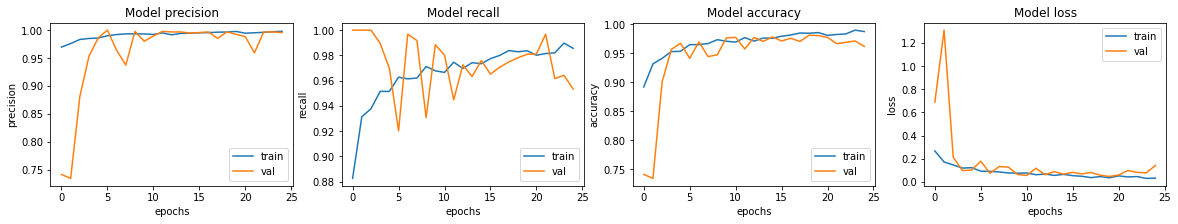

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [41]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 99ms/step - loss: 1.5100 - accuracy: 0.8013 - precision: 0.7649 - recall: 0.9846
Loss: 1.51003098487854,
Accuracy: 0.8012820482254028,
Precision: 0.7649402618408203,
Recall: 0.9846153855323792


위의 방법을 실행해 봤을 때 가장 결과가 좋은 것은 batch normalization만 사용한 경우였다. 여기서 batch size와 epochs만 다시 조절해 fit 해보도록 하겠다. epochs는 30으로 늘리고, batch size는 10으로 줄여 실행해보도록 한다.

In [45]:
EPOCHS = 30
BATCH_SIZE = 10
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
418/418 [==============================] - 101s 225ms/step - loss: 0.0144 - accuracy: 0.9950 - precision: 0.9985 - recall: 0.9947 - val_loss: 0.0614 - val_accuracy: 0.9851 - val_precision: 0.9895 - val_recall: 0.9902
Epoch 2/30
418/418 [==============================] - 94s 224ms/step - loss: 0.0149 - accuracy: 0.9955 - precision: 0.9990 - recall: 0.9949 - val_loss: 0.1456 - val_accuracy: 0.9716 - val_precision: 0.9933 - val_recall: 0.9679
Epoch 3/30
418/418 [==============================] - 92s 220ms/step - loss: 0.0181 - accuracy: 0.9928 - precision: 0.9985 - recall: 0.9918 - val_loss: 0.0706 - val_accuracy: 0.9788 - val_precision: 0.9934 - val_recall: 0.9778
Epoch 4/30
418/418 [==============================] - 92s 220ms/step - loss: 0.0272 - accuracy: 0.9908 - precision: 0.9972 - recall: 0.9904 - val_loss: 0.1231 - val_accuracy: 0.9534 - val_precision: 0.9931 - val_recall: 0.9432
Epoch 5/30
418/418 [==============================] - 93s 222ms/step - loss: 0.0105 - accur

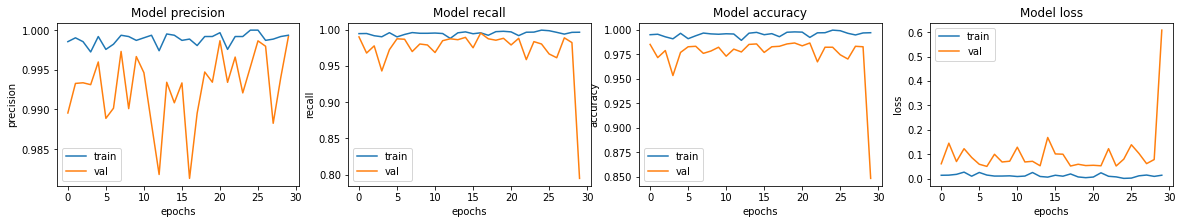

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [47]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 108ms/step - loss: 1.7139 - accuracy: 0.8606 - precision: 0.8722 - recall: 0.9103
Loss: 1.713889479637146,
Accuracy: 0.8605769276618958,
Precision: 0.872235894203186,
Recall: 0.9102563858032227


마지막 방법으로 목표수치를 넘길 수 있었다.

## 회고

모델 학습에 있어서 전반적으로 과적합이 일어난 것으로 보인다. training set에 대한 값은 일정하게 유지되거나 줄어드는 양상을 보이는데, 시도한 방법 대부분에서 validation set에 대해서는 진동하는 형태를 보였고, test set에 대해선 마지막 86퍼센트를 제외하고는 80퍼센트 내외의 성능을 보였다. 이렇게 과적합이 일어날 경우 해결할 수 있는 방법은 크게 네 가지인데, 데이터의 양을 늘리거나, 모델의 복잡도를 줄이거나, 가중치 규제를 적용하거나 드롭아웃을 사용하는 방법이 있다. 다만 이 프로젝트에서 드롭아웃을 사용한 경우 정확도가 떨어졌기 때문에 어떤 이유에서 정확도가 떨어진건지 분석해볼 필요가 있다고 생각한다. 

결론적으로 batch size는 줄이고 epochs를 늘린 뒤, batch normalization만을 사용한 경우가 정확도가 가장 높았다. 시도한 방법별로 구체적인 수치를 정리하면 다음과 같다.

|사용한 방법|epochs|batch size|accuracy|
|:---:|:---:|:---:|:---:|
|-|25|16|76%|
|batch size, epochs 변경|30|20|78%|
|agumentation 도입|25|16|69%|
|정규화에서 dropout만 사용|25|16|79%|
|정규화에서 batch normalization만 사용|25|16|80%|
|정규화에서 batch normalization만 사용|30|10|86%|